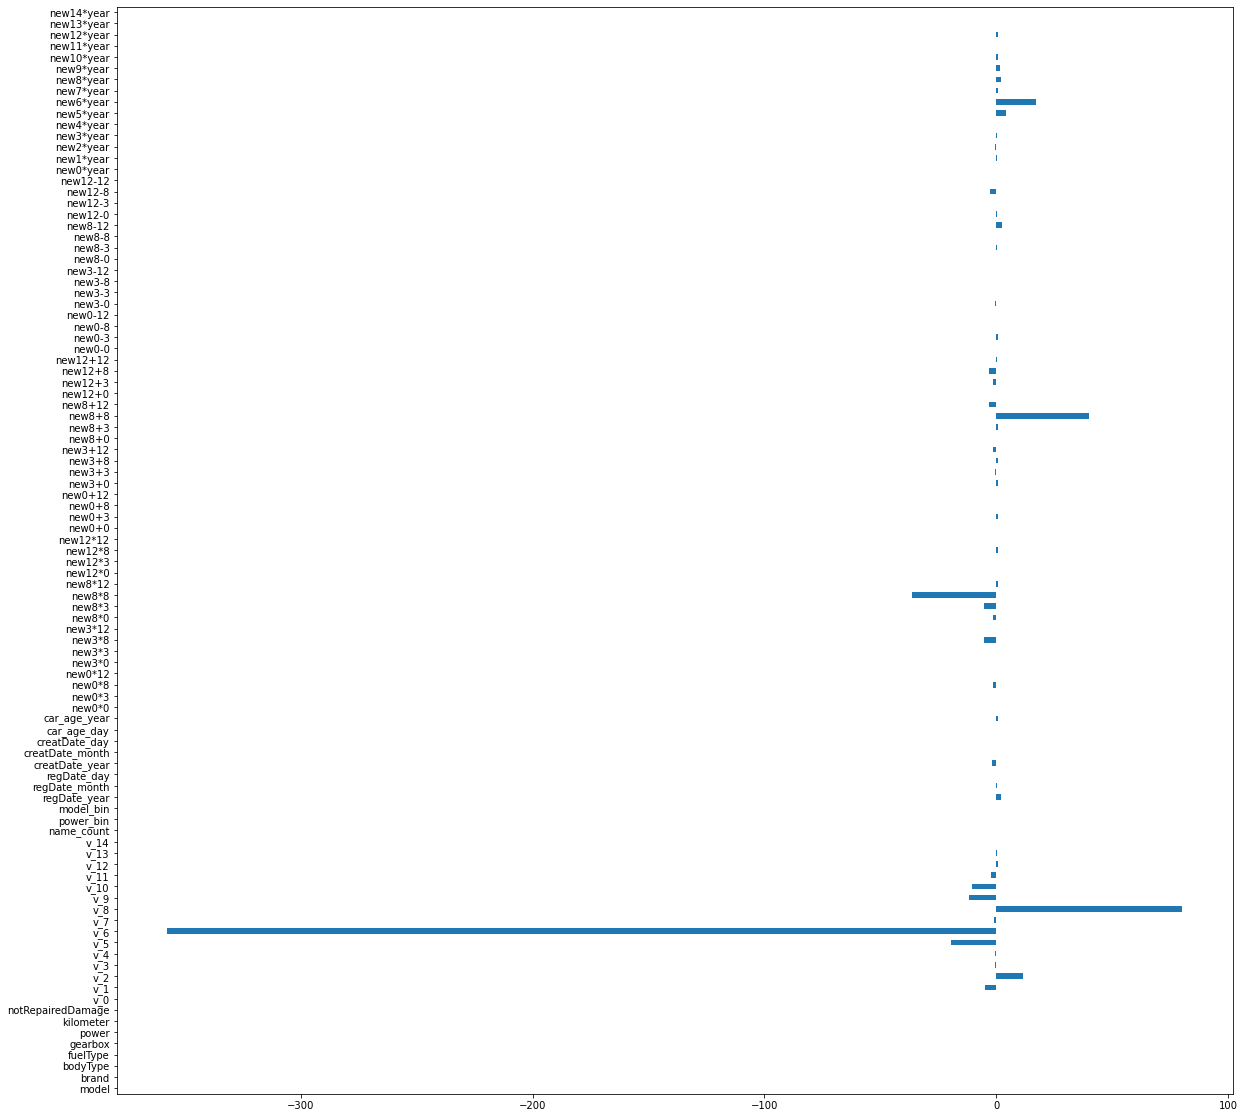

In [30]:
global_importance_lr = pd.Series(lr.coef_, index = train_X.columns.tolist())

fig = plt.figure(figsize=(20,20))
fig = global_importance_lr.plot(kind = 'barh')
plt.savefig(r'../results/lr_fe_importance.png', figsize=(20,20), dpi=300,format="PNG")

In [23]:
from sklearn.neighbors import KNeighborsRegressor
knn_score = []
for k in range(1,52,10):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(train_X, train_Y)
    y_new = neigh.predict(test_X)
    scores = cross_val_score(neigh, X=train_X, y=train_Y, verbose=1, cv = 5, scoring=make_scorer((r2_score)))
    knn_score.append(scores.mean())



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished


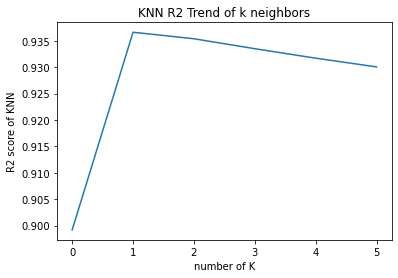

In [24]:
fig = plt.figure(6)
plt.plot(range(6),knn_score)
plt.xlabel("number of K")
plt.ylabel("R2 score of KNN")
plt.title('KNN R2 Trend of k neighbors')
plt.savefig(r'../figures/knn_r2.png', dpi=300,format="PNG")
plt.show()

In [62]:
from sklearn.neighbors import KNeighborsRegressor

df1 = df.copy()
test = df1[df1['price'].isnull()]
X_train = df1[df1['price'].notnull()].drop(['price','regDate','creatDate','SaleID','regionCode'],axis=1)
Y_train = df1[df1['price'].notnull()]['price']
X_test = df1[df1['price'].isnull()].drop(['price','regDate','creatDate','SaleID','regionCode'],axis=1)
train_X = X_train.fillna(-1)
train_Y = Y_train.fillna(-1)
test_X  =X_test.fillna(-1)

oof = np.zeros(train_X.shape[0])
test = df1[df1['price'].isnull()]
sub = test[['SaleID']].copy()
sub['price'] = 0
neigh = KNeighborsRegressor(n_neighbors=11)
skf = KFold(n_splits=5, shuffle=True, random_state=2020)
r2_knn_f = 0

for i, (trn_idx, val_idx) in enumerate(skf.split(train_X, train_Y)):

    print('--------------------- {} fold ---------------------'.format(i+1))
    trn_x, trn_y = train_X.iloc[trn_idx].reset_index(drop=True), train_Y.iloc[trn_idx].reset_index(drop=True)
    val_x, val_y = train_X.iloc[val_idx].reset_index(drop=True), train_Y.iloc[val_idx].reset_index(drop=True)
    
    neigh.fit(trn_x, trn_y)
    sub['price'] += np.expm1(neigh.predict(test_X)) / skf.n_splits
    oof = neigh.predict(val_x)
    print('val r2:', r2_score((val_y), (oof)))
    #print('val r2:', r2_score(np.expm1(val_y), np.expm1(oof[val_idx])))
    #r2_knn_f += r2_score(np.expm1(val_y), np.expm1(oof[val_idx]))/skf.n_splits

--------------------- 1 fold ---------------------
val r2: 0.9344163556680872
--------------------- 2 fold ---------------------
val r2: 0.935766636713851
--------------------- 3 fold ---------------------
val r2: 0.9367311242304459
--------------------- 4 fold ---------------------
val r2: 0.9361262889783548
--------------------- 5 fold ---------------------
val r2: 0.9396407623281339


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

clf = RandomForestRegressor()
clf = clf.fit(train_X, train_Y)

In [46]:
pre=clf.predict(test_X)
scores = cross_val_score(clf, X=train_X, y=train_Y, verbose=1, cv = 2, scoring=make_scorer((r2_score)))
print(scores.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9574660105279242


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 16.6min finished


In [13]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clf, random_state=1).fit(train_X, train_Y)
eli5.show_weights(perm, feature_names=train_X.columns.tolist(), top=97)

Weight,Feature
0.2692 ± 0.0013,new3-0
0.2471 ± 0.0012,new0-3
0.0213 ± 0.0007,new12*year
0.0173 ± 0.0003,new8*year
0.0130 ± 0.0001,new8+3
0.0120 ± 0.0002,notRepairedDamage
0.0108 ± 0.0003,kilometer
0.0102 ± 0.0001,new3+8
0.0079 ± 0.0001,v_14
0.0060 ± 0.0001,new11*year


In [ ]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_X)

In [17]:
from sklearn.model_selection import KFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
trn_x, val_x, trn_y, val_y = train_test_split(train_X, train_Y, test_size=0.25)
clf1 = LGBMRegressor(
    n_estimators=10000,
    learning_rate=0.02,
    boosting_type= 'gbdt',
    objective = 'regression_l1',
    max_depth = -1,
    num_leaves=31,
    min_child_samples = 20,
    feature_fraction = 0.8,
    bagging_freq = 1,
    bagging_fraction = 0.8,
    lambda_l2 = 2,
    random_state=2020,
    metric='mae'
)

clf1.fit(
    trn_x, trn_y,
    eval_set=[(val_x, val_y)],
    eval_metric='mae',
    early_stopping_rounds=50,
    verbose=300
)
oof = clf1.predict(val_x)
print('val R2_score:', r2_score((val_y), (oof)))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[300]	valid_0's l1: 0.1487
[600]	valid_0's l1: 0.13126
[900]	valid_0's l1: 0.125192
[1200]	valid_0's l1: 0.121786
[1500]	valid_0's l1: 0.119562
[1800]	valid_0's l1: 0.117926
[2100]	valid_0's l1: 0.116646
[2400]	valid_0's l1: 0.115662
[2700]	valid_0's l1: 0.114821
[3000]	valid_0's l1: 0.114144
[3300]	valid_0's l1: 0.113563
[3600]	valid_0's l1: 0.113025
[3900]	valid_0's l1: 0.112579
[4200]	valid_0's l1: 0.112102
[4500]	valid_0's l1: 0.1117
[4800]	valid_0's l1: 0.111345
[5100]	valid_0's l1: 0.111044
[5400]	valid_0's l1: 0.11078
[5700]	valid_0's l1:

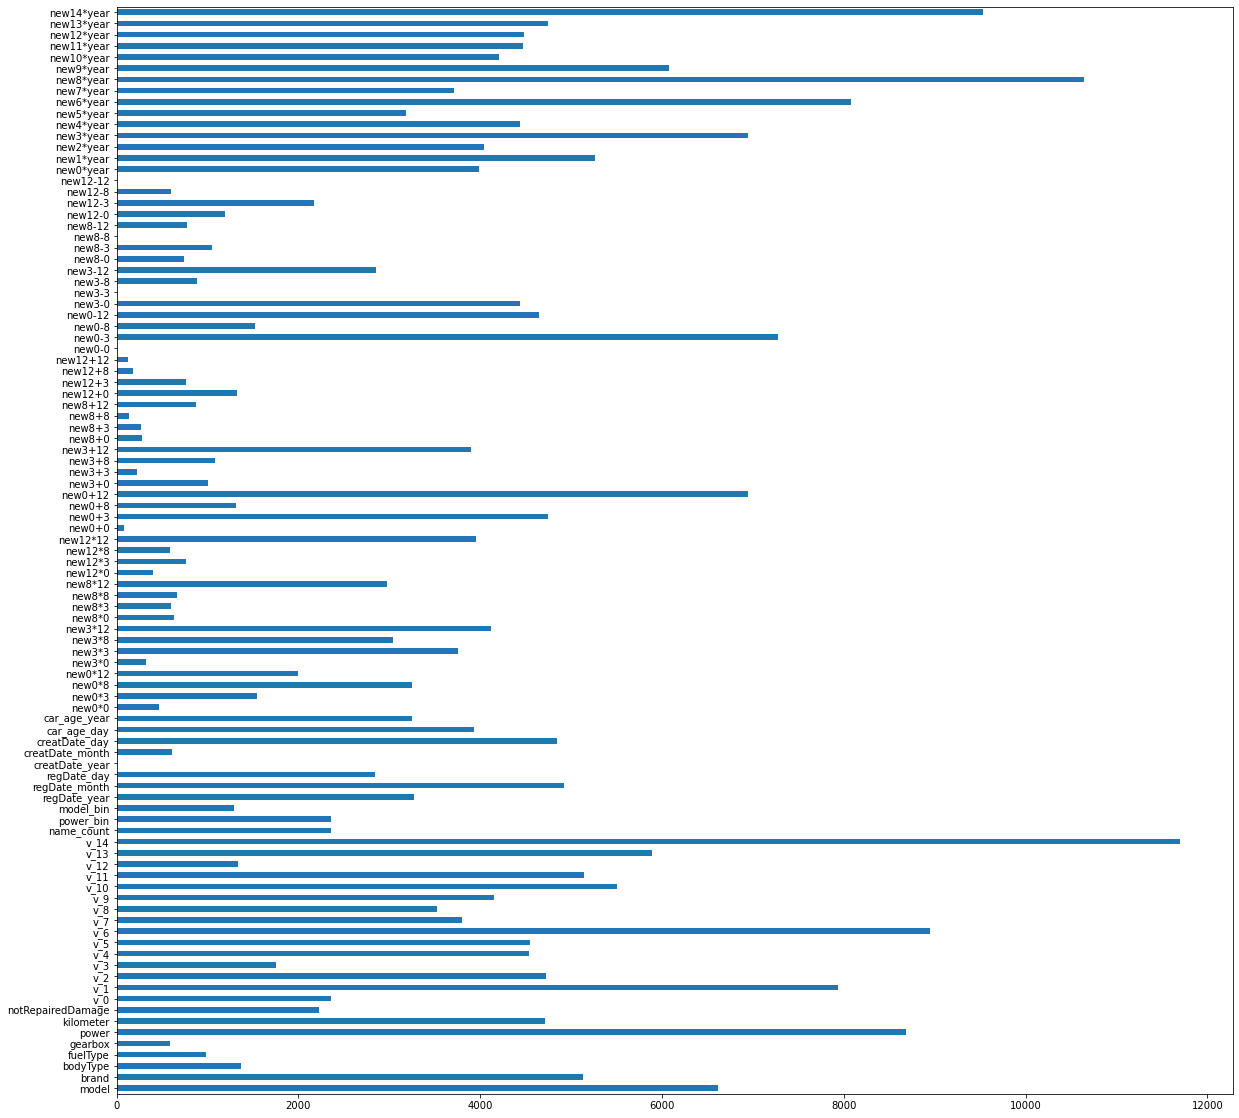

In [24]:
global_importance = pd.Series(clf1.feature_importances_, index = train_X.columns.tolist())

fig = plt.figure(figsize=(20,20))
fig = global_importance.plot(kind = 'barh')
plt.savefig(r'E:\BaiduNetdiskDownload\FinalProj\f\shap2.png', figsize=(20,20), dpi=300,format="PNG")

In [32]:
print(global_importance)

model         6617
brand         5129
bodyType      1363
fuelType       977
gearbox        587
              ... 
new10*year    4208
new11*year    4469
new12*year    4480
new13*year    4748
new14*year    9530
Length: 97, dtype: int32


In [ ]:
sorted(dict(zip(train_X.columns.tolist(), global_importance)).items(), key=lambda x:x[1], reverse=True)